{'orf1ab': 4392.0, 'nsp1': 193.0, 'nsp2': 660.0, 'nsp3': 1887.0, 'nsp4': 507.0, 'nsp5': 306.0, 'nsp6': 292.0, 'nsp7': 83.0, 'nsp8': 199.0, 'nsp9': 110.0, 'nsp10': 140.0, 'hel': 598.0, 'exon': 524.0, 'nendou': 343.0, 'nsp11': 14.0, 's': 1354.0, 'orf3': 104.0, 'orf4a': 110.0, 'orf4b': 247.0, 'orf5': 225.0, 'e': 83.0, 'm': 220.0, 'n': 414.0, 'orf8b': 113.0, 'rdrp': 933.0, '2Omethyltransferase': 303.0, 's1': 732.0, 's2': 602.0}
{'KJ477102': {'region': 'Africa', 'host': 'Camel', 'date': 2013.6677696491379, 'muts_on_path': {}}, 'OP712624': {'region': 'Africa', 'host': 'Camel', 'date': 2016.6844262295083, 'muts_on_path': {'Orf4b': ['R206X', '*247X']}}, 'OP712625': {'region': 'Africa', 'host': 'Camel', 'date': 2016.6844262295083, 'muts_on_path': {'Orf4b': ['R206X', '*247X']}}, 'KJ477103': {'region': 'Africa', 'host': 'Camel', 'date': 2013.9986301369863, 'muts_on_path': {'Orf4b': ['R206X', '*247X']}}, 'OP906306': {'region': 'Africa', 'host': 'Camel', 'date': 2013.9986301369863, 'muts_on_path': 

<Figure size 640x480 with 0 Axes>

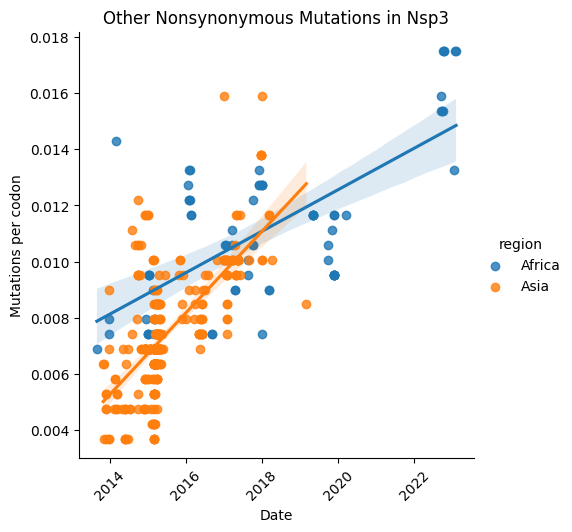

<Figure size 640x480 with 0 Axes>

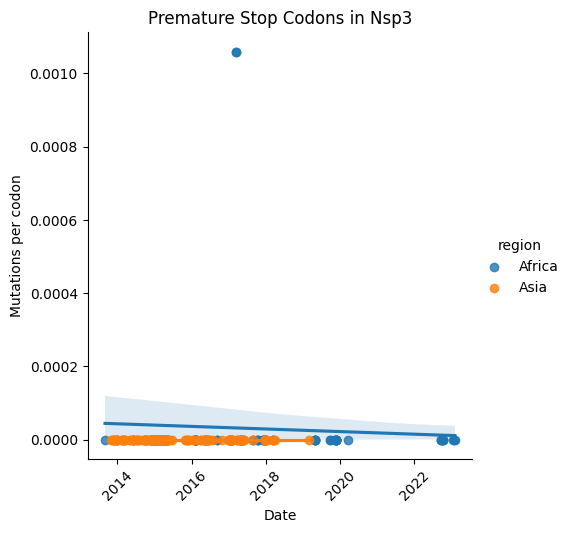

Africa:
Nonsyn rate = 0.0007389535840713713 mutations per codon per year; p = 7.507550414056965e-12
Stop rate = -3.5462014285841827e-06 mutations per codon per year; p = 0.6528821135626983
Asia:
Nonsyn rate = 0.0014534494963091417 mutations per codon per year; p = 4.618505015283912e-46
Stop rate = 0.0 mutations per codon per year; p = 1.0


<Figure size 640x480 with 0 Axes>

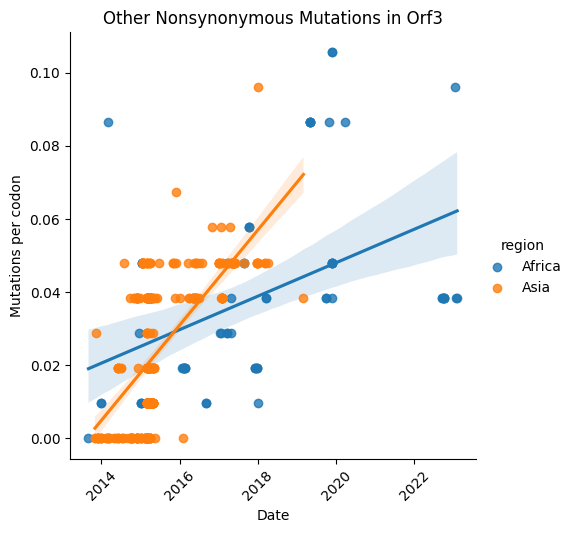

<Figure size 640x480 with 0 Axes>

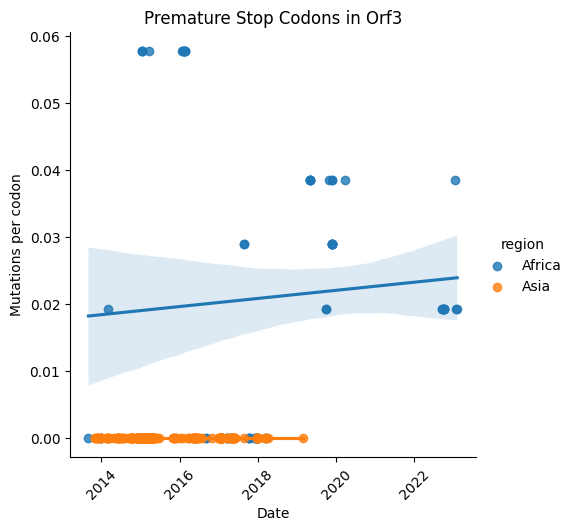

Africa:
Nonsyn rate = 0.004579643727796923 mutations per codon per year; p = 4.61766460619541e-05
Stop rate = 0.0006059701729731169 mutations per codon per year; p = 0.5365384891638161
Asia:
Nonsyn rate = 0.013021325602871484 mutations per codon per year; p = 2.8942275894152436e-41
Stop rate = 0.0 mutations per codon per year; p = 1.0


<Figure size 640x480 with 0 Axes>

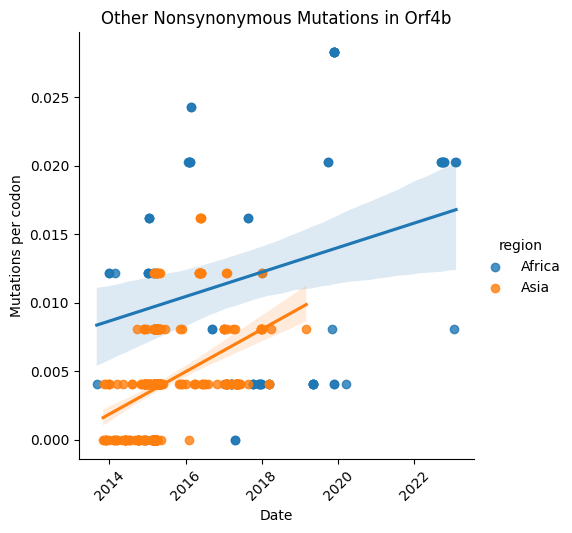

<Figure size 640x480 with 0 Axes>

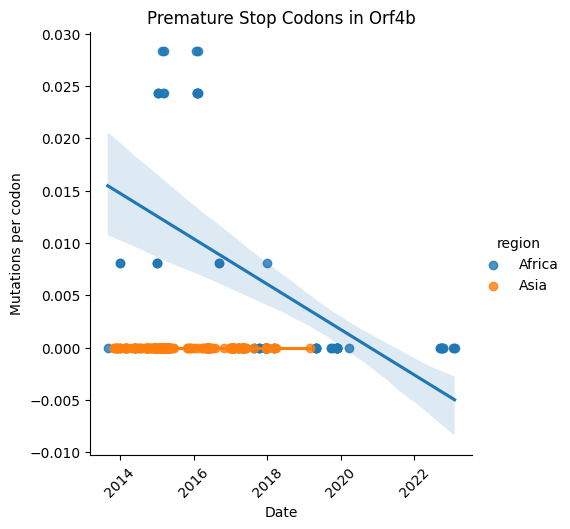

Africa:
Nonsyn rate = 0.0008950883461847591 mutations per codon per year; p = 0.01973498642133061
Stop rate = -0.002170006590591842 mutations per codon per year; p = 3.1384358663263493e-07
Asia:
Nonsyn rate = 0.0015504273054370427 mutations per codon per year; p = 3.425141544840628e-15
Stop rate = 0.0 mutations per codon per year; p = 1.0


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import json
from Bio import SeqIO
import scipy

stop_mut_and_host_info_file = "../../only_camels/stop_vs_nonsyn/stop_mut_and_host_info_by_tip.json"
with open(stop_mut_and_host_info_file, 'r') as infile:
    stop_by_tip = json.load(infile)

nonstop_mut_and_host_info_file = "../../only_camels/stop_vs_nonsyn/no_stop_mut_and_host_info_by_tip.json"
with open(nonstop_mut_and_host_info_file, 'r') as infile:
    nonstop_by_tip = json.load(infile)

def extract_gene_lengths(genbank_file):
    gene_lengths = {}
    for record in SeqIO.parse(genbank_file, "genbank"):
        for feature in record.features:
            if feature.type == "mat_peptide": 
                gene_name = feature.qualifiers.get("product", ["unknown"])[0]
                gene_name = gene_name.replace(' protein', "")
                gene_length = len(feature.location)
                gene_lengths[gene_name.lower()] = gene_length / 3
            elif feature.type == "CDS":  
                gene_name = feature.qualifiers.get("gene", ["unknown"])[0]
                gene_length = len(feature.location)
                gene_lengths[gene_name.lower()] = gene_length / 3
        gene_lengths['rdrp'] = gene_lengths.pop("rna-dependent rna polymerase")
        gene_lengths['2Omethyltransferase'] = gene_lengths.pop("2'-o-methyltransferase")
    return gene_lengths

genbank_file = "../../../../nextstrain-build/phylogenetic_only_camels/defaults/mers_reference.gb"

gene_codon_counts = extract_gene_lengths(genbank_file)
gene_codon_counts["s1"] = 2196 / 3
gene_codon_counts["s2"] = 1806 / 3

print(gene_codon_counts)
print(stop_by_tip)
all_genes = ['Nsp3','Orf3', 'Orf4b']

def calc_rates(mut_and_host_info_by_tip):
    data = []
    for tip, info in mut_and_host_info_by_tip.items():
        row = {'sample': tip, 'region': info['region'], 'date': info['date']}
        muts_on_path = info.get('muts_on_path', {})
        for gene in all_genes:
            num_mutations = len(muts_on_path.get(gene, []))
            gene = gene.lower()
            num_codons = gene_codon_counts[gene] 
            mutation_rate = num_mutations / num_codons
            row[gene] = mutation_rate
        data.append(row)
    return data, all_genes


stop_data, _ = calc_rates(stop_by_tip)
stop_df = pd.DataFrame(stop_data)
nonstop_data, all_genes = calc_rates(nonstop_by_tip)
nonstop_df = pd.DataFrame(nonstop_data)


lin_regress = {}
lin_regress_all = {}
count = 0
for gene in all_genes:
    gene_lower = gene.lower()
    # Plot for Non-Synonymous Mutations
    plt.figure()
    sns.lmplot(x='date', y=gene_lower, hue='region', data=nonstop_df)
    plt.title("Other Nonsynonymous Mutations in " + gene)
    plt.xlabel('Date')
    plt.ylabel('Mutations per codon')
    plt.xticks(rotation=45)
    plt.show()

    # Plot for Premature Stop Codons
    plt.figure()
    sns.lmplot(x='date', y=gene_lower, hue='region', data=stop_df)
    plt.title("Premature Stop Codons in " + gene)
    plt.xlabel('Date')
    plt.ylabel('Mutations per codon')
    plt.xticks(rotation=45)
    plt.show()
    
    lin_regress[gene] = {}
    lin_regress_all[gene] = {}
    
    # Stop results (Africa)
    lin_regress[gene]['Africa'] = {}
    lin_regress_all[gene]['Africa'] = {}
    x_stop = stop_df.query("region == 'Africa'")['date']
    y_stop = stop_df.query("region == 'Africa'")[gene_lower]
    stop_slope, stop_intercept, stop_r, stop_p, stop_se = stats.linregress(x_stop, y_stop)
    lin_regress[gene]['Africa']['Stop'] = stop_slope
    lin_regress_all[gene]['Africa']['Stop'] = {'slope': stop_slope, 'intercept': stop_intercept, 'r': stop_r, 'p': stop_p, 'se': stop_se}

    # Non-Stop results (Africa)
    x_nonstop = nonstop_df.query("region == 'Africa'")['date']
    y_nonstop = nonstop_df.query("region == 'Africa'")[gene_lower]
    nonstop_slope, nonstop_intercept, nonstop_r, nonstop_p, nonstop_se = stats.linregress(x_nonstop, y_nonstop)
    lin_regress[gene]['Africa']['Non-Stop'] = nonstop_slope
    lin_regress_all[gene]['Africa']['Non-Stop'] = {'slope': nonstop_slope, 'intercept': nonstop_intercept, 'r': nonstop_r, 'p': nonstop_p, 'se': nonstop_se}

    # Stop results (Asia)
    lin_regress[gene]['Asia'] = {}
    lin_regress_all[gene]['Asia'] = {}
    x_stop = stop_df.query("region == 'Asia'")['date']
    y_stop = stop_df.query("region == 'Asia'")[gene_lower]
    stop_slope, stop_intercept, stop_r, stop_p, stop_se = stats.linregress(x_stop, y_stop)
    lin_regress[gene]['Asia']['Stop'] = stop_slope
    lin_regress_all[gene]['Asia']['Stop'] = {'slope': stop_slope, 'intercept': stop_intercept, 'r': stop_r, 'p': stop_p, 'se': stop_se}

    # Non-Stop results (Asia)
    x_nonstop = nonstop_df.query("region == 'Asia'")['date']
    y_nonstop = nonstop_df.query("region == 'Asia'")[gene_lower]
    nonstop_slope, nonstop_intercept, nonstop_r, nonstop_p, nonstop_se = stats.linregress(x_nonstop, y_nonstop)
    lin_regress[gene]['Asia']['Non-Stop'] = nonstop_slope
    lin_regress_all[gene]['Asia']['Non-Stop'] = {'slope': nonstop_slope, 'intercept': nonstop_intercept, 'r': nonstop_r, 'p': nonstop_p, 'se': nonstop_se}

    # Z-test
    # numerator = stop_slope - nonstop_slope
    # denominator = ((stop_se ** 2) + (nonstop_se ** 2)) ** 0.5
    # z = numerator / denominator
    # p = scipy.stats.norm.sf(abs(z)) * 2
    
    count += 1
    print("Africa:"),
    print("Nonsyn rate = " + str(lin_regress[gene]['Africa']['Non-Stop']) + " mutations per codon per year; p = " + str(lin_regress_all[gene]['Africa']['Non-Stop']['p'])),
    print("Stop rate = " + str(lin_regress[gene]['Africa']['Stop']) + " mutations per codon per year; p = " + str(lin_regress_all[gene]['Africa']['Stop']['p'])),

    print("Asia:"),
    print("Nonsyn rate = " + str(lin_regress[gene]['Asia']['Non-Stop']) + " mutations per codon per year; p = " + str(lin_regress_all[gene]['Asia']['Non-Stop']['p'])),
    print("Stop rate = " + str(lin_regress[gene]['Asia']['Stop']) + " mutations per codon per year; p = " + str(lin_regress_all[gene]['Asia']['Stop']['p'])),
    



#print(lin_regress)
df_results = pd.DataFrame(lin_regress)
df_results_all = pd.DataFrame(lin_regress_all)
# linear_regression_results = df_results.to_csv('../../intermediate-results-downsampling/linear_regression_results.csv')
# linear_regression_results_all = df_results_all.to_csv('../../intermediate-results-downsampling/linear_regression_results_all.csv')
